### Summary
Segmenting the test dataset

In [2]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [209]:
# paths
data_dir = 'data/'
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

In [85]:
df_labels = pd.read_csv(os.path.join(data_dir, 'stage1_train_labels.csv'))

In [210]:
df_labels[:5]

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [214]:
# get random image id
np.random.seed(23)
random_image = df_labels.sample(1)
tmp_imageid = str(random_image.get_value(random_image.index[0],'ImageId'))

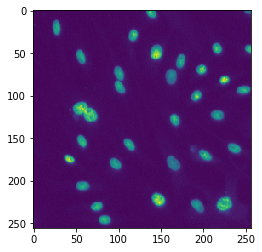

In [215]:
tmp_image_path = os.path.join(TRAIN_PATH,tmp_imageid,'images',tmp_imageid+'.png')
tmp_image_path
tmp_image = cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(tmp_image)

In [216]:
# list mask directory files
tmp_mask_dir = os.listdir(os.path.join(TRAIN_PATH,tmp_imageid,'masks'))

In [217]:
# list mask image paths
tmp_mask_path = [os.path.join(TRAIN_PATH,tmp_imageid,'masks',mask) for mask in tmp_mask_dir]

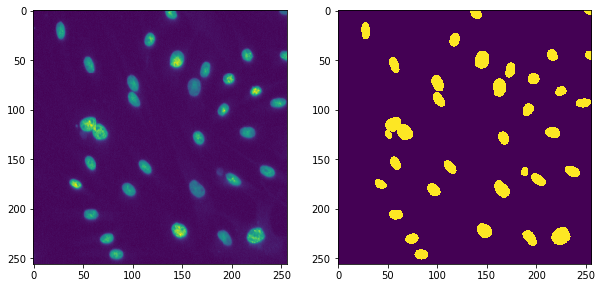

In [218]:
# find shape
mask0 = cv2.imread(tmp_mask_path[0], cv2.IMREAD_GRAYSCALE)
height = mask0.shape[0]
width = mask0.shape[1]
# make black image
im = np.zeros([height,width],dtype=np.uint8)
# combine masks 
for mask in tmp_mask_path:
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    im = im + mask
tmp_mask = im
# plot
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(tmp_mask)

### Segmentation
We use an "Otsu" threshold method to model the image as a bimodal distriubtions to separate the foreground (cells) from the background. 

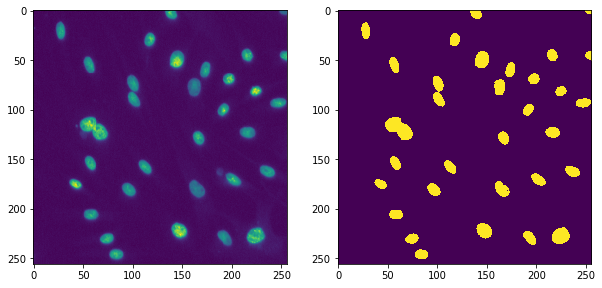

In [223]:
# OTSU threshold
_, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU)
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)

In [227]:
# resolution and size
tmp_image.shape, tmp_image.size

((256, 256), 65536)

In [228]:
# min max pixel values
tmp_image.min(), tmp_image.max()

(2, 131)

In [229]:
# mean pixel value
tmp_image.mean()

10.402206420898438

### Histogram equalization
There are faint cells blended in with the background that the threshold method does not pick up. We will equalize the image to redistribute the contrast and try to make the faint cells more pronounced.

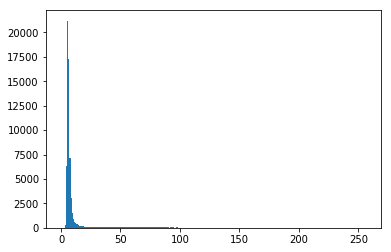

In [231]:

hist = cv2.calcHist([tmp_image],[0],None,[256],[0,256])
plt.hist(tmp_image.ravel(),256,[0,256])
plt.show()

In [232]:
hist.min(),hist.max()

(0.0, 21193.0)

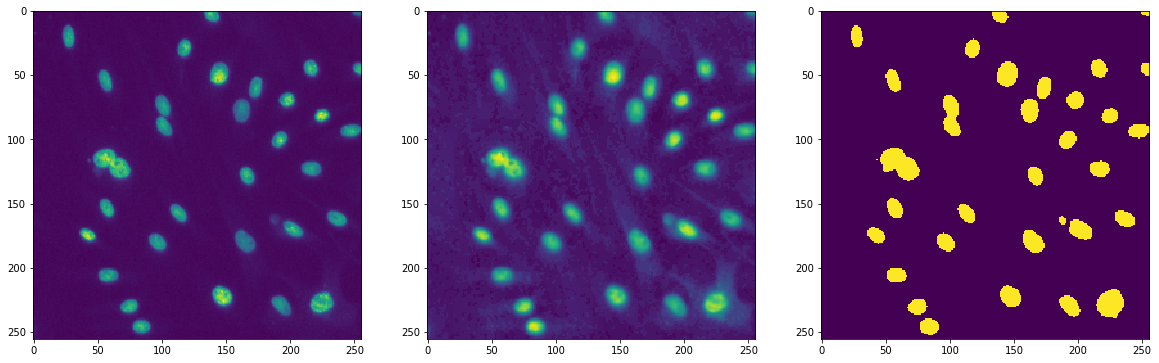

In [233]:
# create a CLAHE object (Arguments are optional).
# adaptive histogram equalization
blur = cv2.GaussianBlur(tmp_image,(3,3),0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(blur)
cl2 = clahe.apply(cl1)
_, thresh_cl2 = cv2.threshold(cl2, 100, 255, cv2.THRESH_OTSU)
fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(tmp_image)
axs[1].imshow(cl2)
axs[2].imshow(thresh_cl2)

### Run Length Encoding (RLE)
https://www.kaggle.com/paulorzp/fast-run-length-encode

https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [60]:
def rle (img):
    #takes an image numpy array with 1 - mask, 0 - background
    #converts to RLE

    bytes = np.where(img.flatten()==255)[0]
    runs = []
    prev = -2
    for b in bytes:
        if (b>prev+1): runs.extend((b+1, 0))
        runs[-1] += 1
        prev = b
    
    return ' '.join([str(i) for i in runs])

In [61]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [64]:
mask_rle = rle(thresh_cl2)
print(mask_rle[:100])

16299 2 16926 4 16939 5 17566 4 17578 7 18206 5 18219 10 18845 1 18847 5 18859 16 19483 9 19498 17 2


In [68]:
shape = thresh_cl2.shape
print(shape)

(512, 640)


In [69]:
thresh_cl2_decode = rle_decode(mask_rle,shape)

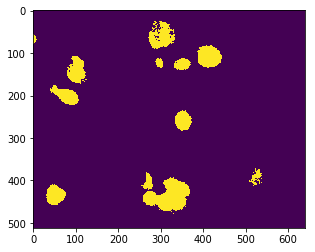

In [70]:
plt.imshow(thresh_cl2)

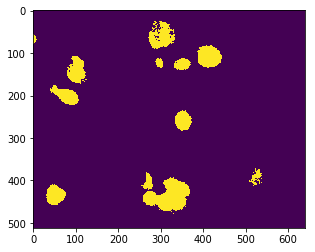

In [73]:
plt.imshow(thresh_cl2_decode)

In [72]:
thresh_cl2_decode

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Intersection of Union IoU test for accuracy
Intersection of union (IoU) is an evaluation method for object detection. This method compares the labeled cell masks with the predicted cell masks. IoU is the area of overlap divided by the area of union. When the IoU is one the prediction is a perfect match with the labeled cell mask. 

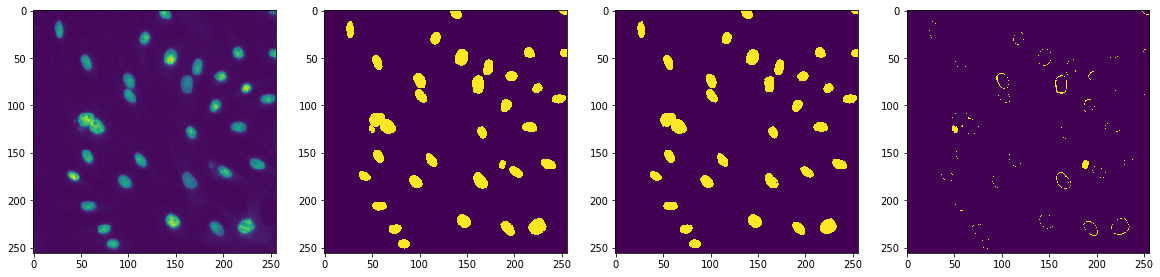

In [322]:
# intersection
intersection = tmp_mask & thresh
# union
union = tmp_mask | thresh
# symemetric difference
difference = (tmp_mask | thresh) - (tmp_mask & thresh)
fig, axs = plt.subplots(1, 4, figsize=(20,20))
axs[0].imshow(tmp_image) 
axs[1].imshow(tmp_mask) 
axs[2].imshow(intersection)
axs[3].imshow(difference)

In [325]:
iou = intersection.sum() / union.sum()
iou

0.90015327348368734

0.80498374864572053

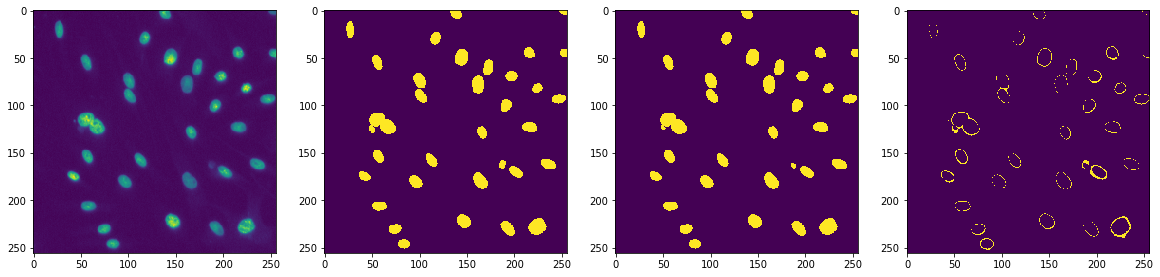

In [327]:
# intersection
intersection = tmp_mask & thresh_cl2
# union
union = tmp_mask | thresh_cl2
# symemetric difference
difference = (tmp_mask | thresh_cl2) - (tmp_mask & thresh_cl2)
fig, axs = plt.subplots(1, 4, figsize=(20,20))
axs[0].imshow(tmp_image) 
axs[1].imshow(tmp_mask) 
axs[2].imshow(intersection)
axs[3].imshow(difference)
intersection.sum() / union.sum()

### Watershed
http://cmm.ensmp.fr/~beucher/wtshed.html

In [360]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# identify sure background
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# identify sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# identify the unknown region. could be foreground or background
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

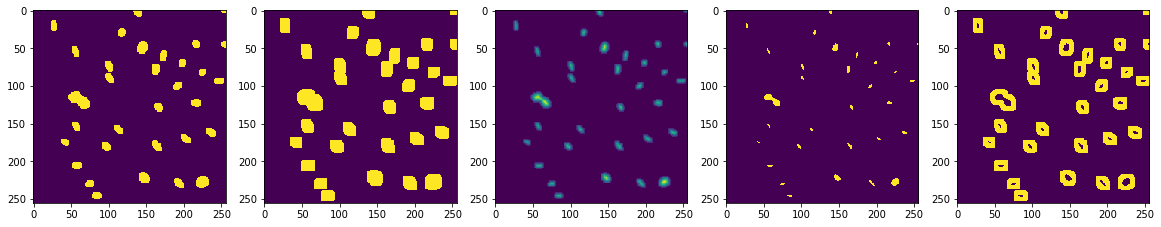

In [361]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(opening)
axs[1].imshow(sure_bg)
axs[2].imshow(dist_transform)
axs[3].imshow(sure_fg)
axs[4].imshow(unknown)

In [376]:
#create markers for watershed
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = markers.astype('int32')

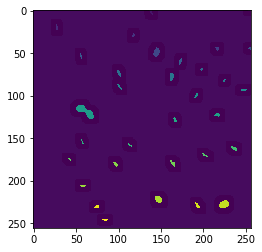

In [377]:
plt.imshow(markers)

In [365]:
tmp_image_3ch = cv2.imread(tmp_image_path, 1)
markers = cv2.watershed(tmp_image_3ch,markers)
tmp_image_3ch[markers == -1] = [255,0,0]

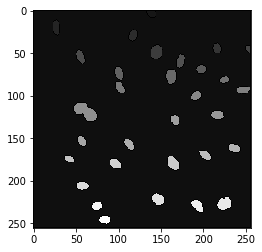

In [386]:
tmp_image_3ch = cv2.imread(tmp_image_path, 1)
markers = cv2.watershed(tmp_image_3ch,markers)
plt.set_cmap('gray')
plt.imshow(markers)

I'd like to get the mask from this watershed method but not sure how. 
https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv

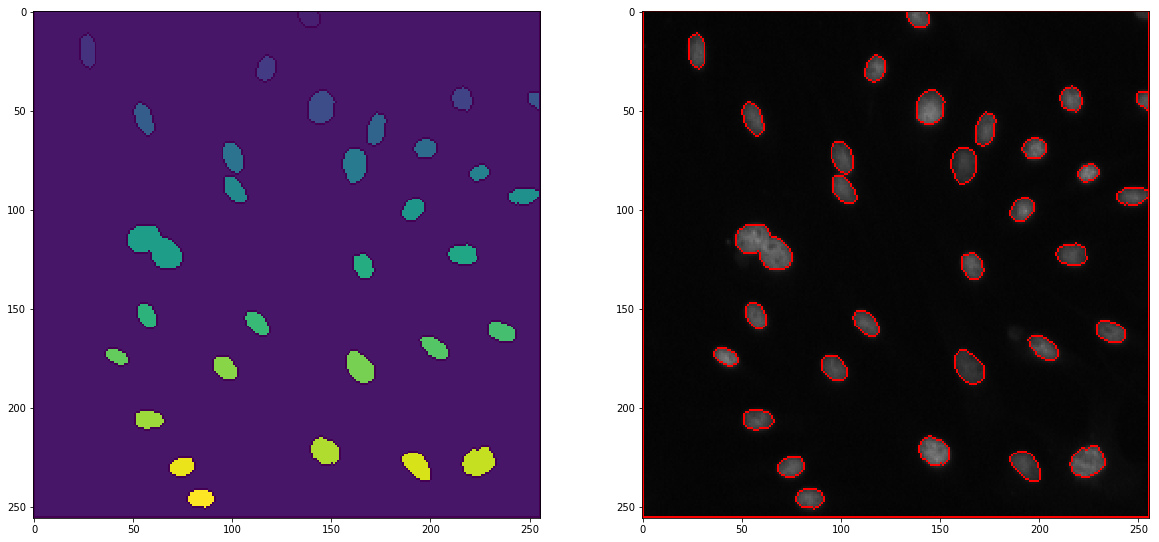

In [367]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].imshow(markers)
axs[1].imshow(tmp_image_3ch)

0.28337777438285905

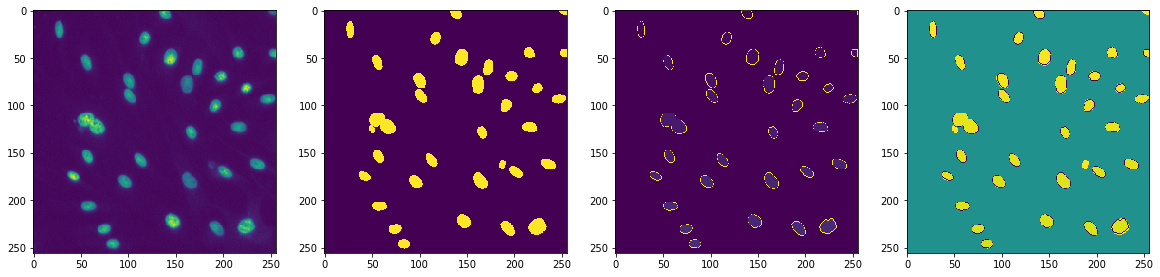

In [368]:
# intersection
intersection = tmp_mask & markers
# union
union = tmp_mask | markers
# symemetric difference
difference = (tmp_mask | markers) - (tmp_mask & markers)
fig, axs = plt.subplots(1, 4, figsize=(20,20))
axs[0].imshow(tmp_image) 
axs[1].imshow(tmp_mask) 
axs[2].imshow(intersection)
axs[3].imshow(difference)
intersection.sum() / union.sum()

markers is not in the right colormap or something which is causing the intersection to be to be the difference. 

## This code needs to be integrated with rest of the notebook (IN PROGRESS)

### inverts the image if the image is a flourescent

In [17]:
# Invert image if background is white and foreground is dark
_, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

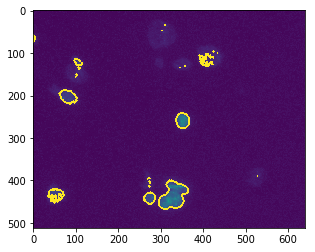

In [18]:
image1 = image.copy()
cv2.drawContours(image1, cnts,-1,(255,255,),3)
plt.imshow(image1)

In [19]:
max_cnt_area = cv2.contourArea(cnts[0])
print("The area of the largest object is: {0}".format(max_cnt_area))

The area of the largest object is: 2880.0


In [20]:
# if the image is a white background and dark cells
# contour will be very large. If the contour area is large
# invert the image so that background is dark and foreground is white
if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

In [21]:
# Remove any small holes in the object we use mor
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

### Finding markers with mahotas for Watershed

alternative to finding markers than using distant transform. Uses regional maximum instead

In [154]:
import mahotas as mh


In [155]:
dnaf = mh.gaussian_filter(image, 8)
rmax = mh.regmax(dnaf)

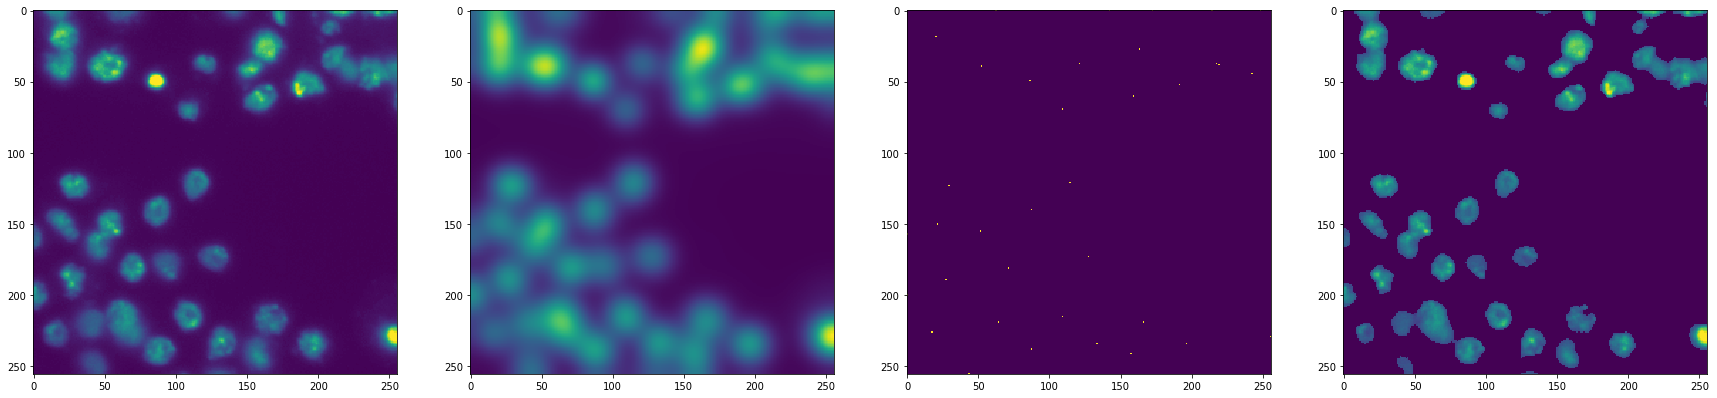

In [157]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(image)
axs[1].imshow(dnaf)
axs[2].imshow(rmax)
axs[3].imshow(cv2.bitwise_and(image, image, mask=mask))

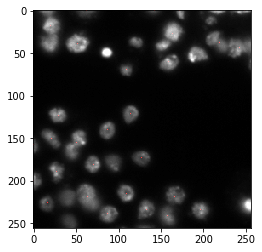

In [158]:
plt.imshow(mh.overlay(image,rmax))

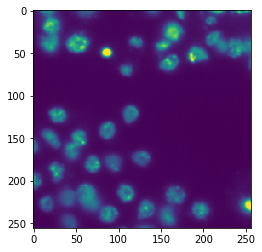

In [159]:
plt.imshow(image)

### Combine into functions (IN PROGRESS)

I'd like to combine the code into functions for readibility and execution'

### Resources
https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229

http://cmm.ensmp.fr/~beucher/wtshed.html

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html

https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies